In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from collections import Counter

%matplotlib inline
%precision %.4f

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import homogeneity_score, completeness_score, silhouette_score, rand_score
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation
from sklearn.utils import check_array, check_scalar, check_random_state
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

N = 50

Рассмотрим датасет, который содержит различные характеристики зданий в Нью-Йорке. Интересно попробовать кластеризовать здания по районам (признак Borough)

In [89]:
df = pd.concat(
        [pd.read_csv(os.path.join("./data", file))[::N] for file in os.listdir("./data") if file.endswith(".csv")],
        ignore_index=True)
df.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version
0,MN,1,10,101,5.00,1018.0,2.0,1.0,10004.0,E007,...,190225.0,16a,Y,199 999,10101.0,NaN,0.000000e+00,NaN,1,16V2
1,MN,11,12,101,9.00,1004.0,2.0,1.0,10004.0,L015,...,196060.0,12b,NaN,101S001,10101.0,NaN,0.000000e+00,NaN,1,16V2
2,MN,16,7510,101,317.04,4000.0,2.0,1.0,10280.0,E010,...,197083.0,12b,NaN,101S089,10101.0,NaN,1.000160e+09,11/20/1991,1,16V2
3,MN,25,7,101,9.00,1000.0,2.0,1.0,10004.0,L015,...,196324.0,12b,NaN,101S005,10101.0,NaN,1.000250e+09,04/25/2013,1,16V2
4,MN,31,7501,101,7.00,1018.0,2.0,1.0,10005.0,L015,...,196142.0,12b,NaN,101S006,10101.0,NaN,1.000310e+09,05/26/2009,1,16V2


In [90]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17170 entries, 0 to 17169
Data columns (total 84 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Borough        17170 non-null  object 
 1   Block          17170 non-null  int64  
 2   Lot            17170 non-null  int64  
 3   CD             17170 non-null  int64  
 4   CT2010         17087 non-null  float64
 5   CB2010         16741 non-null  float64
 6   SchoolDist     17109 non-null  float64
 7   Council        17109 non-null  float64
 8   ZipCode        17078 non-null  float64
 9   FireComp       17093 non-null  object 
 10  PolicePrct     17107 non-null  float64
 11  HealthArea     17103 non-null  float64
 12  SanitBoro      17026 non-null  float64
 13  SanitDistrict  17028 non-null  float64
 14  SanitSub       16877 non-null  object 
 15  Address        17157 non-null  object 
 16  ZoneDist1      17161 non-null  object 
 17  ZoneDist2      505 non-null    object 
 18  ZoneDi

Посмотрим на распределение признака Borough

<Axes: xlabel='Borough', ylabel='count'>

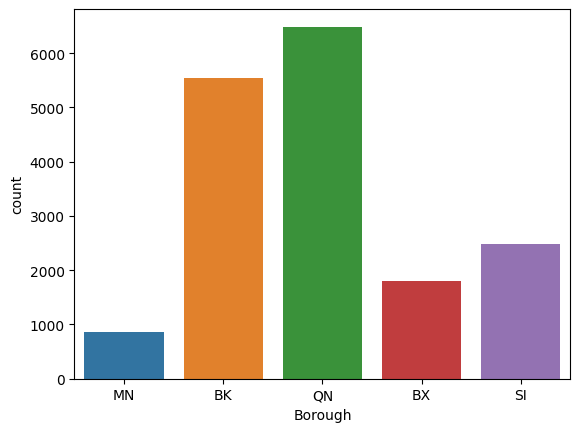

In [91]:
sns.countplot(data=df, x="Borough", hue="Borough")

Рассмотрим количество пропущенных значений в каждой колонке. Также выведем процент пропущенных значений.

In [92]:
for col in df:
    nan_count = df[col].isna().sum()
    print(col, nan_count, nan_count/len(df)*100)

Borough 0 0.0
Block 0 0.0
Lot 0 0.0
CD 0 0.0
CT2010 83 0.483401281304601
CB2010 429 2.498543972044263
SchoolDist 61 0.355270821199767
Council 61 0.355270821199767
ZipCode 92 0.535818287711124
FireComp 77 0.44845661036691903
PolicePrct 63 0.36691904484566107
HealthArea 67 0.39021549213744905
SanitBoro 144 0.8386721025043681
SanitDistrict 142 0.8270238788584741
SanitSub 293 1.7064647641234714
Address 13 0.075713453698311
ZoneDist1 9 0.052417006406523005
ZoneDist2 16665 97.05882352941177
ZoneDist3 17162 99.95340710541643
ZoneDist4 17170 100.0
Overlay1 15547 90.54746651135702
Overlay2 17166 99.97670355270822
SPDist1 15242 88.77111240535818
SPDist2 17169 99.99417588817705
SPDist3 17170 100.0
LtdHeight 17109 99.64472917880023
SplitZone 12 0.06988934187536401
BldgClass 12 0.06988934187536401
LandUse 62 0.36109493302271406
Easements 0 0.0
OwnerType 14976 87.22189866045427
OwnerName 151 0.8794408852649972
LotArea 0 0.0
BldgArea 0 0.0
ComArea 0 0.0
ResArea 0 0.0
OfficeArea 0 0.0
RetailArea 0 0.0

Заметим, что есть много колонок где доля пропущенных значений достаточно велика (в некоторых случаях -- почти 100%). Отбросим колонки с высоким содержанием таких значений.

In [93]:
bad_cols = df.isna().sum() / len(df) * 100 > 55
for column in bad_cols.index:
    if bad_cols[column]:
        df.drop(column, axis=1, inplace=True)
df.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,Sanborn,TaxMap,APPBBL,PLUTOMapID,Version
0,MN,1,10,101,5.00,1018.0,2.0,1.0,10004.0,E007,...,0,5,979071.0,190225.0,16a,199 999,10101.0,0.000000e+00,1,16V2
1,MN,11,12,101,9.00,1004.0,2.0,1.0,10004.0,L015,...,0,9,980889.0,196060.0,12b,101S001,10101.0,0.000000e+00,1,16V2
2,MN,16,7510,101,317.04,4000.0,2.0,1.0,10280.0,E010,...,779,31704,979649.0,197083.0,12b,101S089,10101.0,1.000160e+09,1,16V2
3,MN,25,7,101,9.00,1000.0,2.0,1.0,10004.0,L015,...,0,9,981208.0,196324.0,12b,101S005,10101.0,1.000250e+09,1,16V2
4,MN,31,7501,101,7.00,1018.0,2.0,1.0,10005.0,L015,...,1836,7,981999.0,196142.0,12b,101S006,10101.0,1.000310e+09,1,16V2


In [94]:
for column in ['XCoord', 'YCoord', 'CB2010']:
    df[column] = df.groupby('Block')[column].transform(lambda x: x.fillna(x.mean()))

В остальных столбцах количество пропущенных значений не превышает одного процента, поэтому можно отброситть такие записи.

In [95]:
df.dropna(how='any', inplace=True)
df.reset_index(drop=True, inplace=True)

In [96]:
for col in df:
    print(col, df[col].nunique())

Borough 5
Block 9982
Lot 527
CD 59
CT2010 1271
CB2010 265
SchoolDist 32
Council 51
ZipCode 175
FireComp 348
PolicePrct 76
HealthArea 205
SanitBoro 5
SanitDistrict 18
SanitSub 45
Address 16592
ZoneDist1 130
SplitZone 2
BldgClass 147
LandUse 11
Easements 3
OwnerName 16367
LotArea 3829
BldgArea 4005
ComArea 1185
ResArea 3467
OfficeArea 353
RetailArea 663
GarageArea 140
StrgeArea 122
FactryArea 106
OtherArea 299
AreaSource 4
NumBldgs 18
NumFloors 46
UnitsRes 143
UnitsTotal 151
LotFront 1484
LotDepth 1684
BldgFront 662
BldgDepth 685
ProxCode 4
IrrLotCode 2
LotType 9
BsmtCode 6
AssessLand 10156
AssessTot 7221
ExemptLand 1756
ExemptTot 2047
YearBuilt 143
YearAlter1 72
YearAlter2 36
BuiltFAR 627
ResidFAR 26
CommFAR 15
FacilFAR 19
BoroCode 5
BBL 16616
CondoNo 1
Tract2010 1267
XCoord 15296
YCoord 15239
ZoneMap 118
Sanborn 4622
TaxMap 714
APPBBL 1440
PLUTOMapID 3
Version 1


Заметим, что столбцы CondoNo и Version имеют только одно уникальное значение, поэтому можем их отбросить

In [97]:
df.drop(columns=['Version',"CondoNo"], inplace=True)

Также избавимся от колонок с текстовой информацией

In [98]:
df.drop(columns=['Address', 'OwnerName'], inplace=True)

Закодируем значения категориальных колонок:

In [99]:
for column in ['SplitZone', 'IrrLotCode']:
    df[column] = df[column].apply(lambda x: x == "Y")

cat_rules = {}
for column in ['Borough', 'FireComp', 'SanitSub', 'ZoneDist1', 'BldgClass', 'ZoneMap', 'Sanborn']:
    cat_rules[column] = {
        'to': {c: i for i, c in enumerate(df[column].unique())},
        'from': {i: c for i, c in enumerate(df[column].unique())}
    }
    df[column] = df[column].apply(lambda x: cat_rules[column]['to'][x])

## Custom K-means

Реализация алгоритма K-means

In [100]:
class CustomKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=10, *, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.tol = tol
        self.random_state = random_state

    def predict(self, x):
        check_is_fitted(self)
        return self._get_labels(check_array(x))

    def fit(self, x, y=None):
        self.n_clusters = check_scalar(self.n_clusters, "n_clusters", int, min_val=1)
        self.tol = check_scalar(self.tol, "tol", float, min_val=0)
        self.random_state_ = check_random_state(self.random_state)
        x = check_array(x)

        self.n_features_in_ = x.shape[1]
        self.cluster_centers_ = x[self.random_state_.choice(len(x), size=self.n_clusters, replace=False), :]
        max_center_shift = np.inf

        while max_center_shift > self.tol:
            self.labels_ = self._get_labels(x)

            new = np.empty((self.n_clusters, self.n_features_in_))
            for i in np.unique(self.labels_):
                new[i] = np.mean(x[self.labels_ == i], axis=0)

            max_center_shift = np.max(np.linalg.norm(self.cluster_centers_ - new, axis=1))

            self.cluster_centers_ = new

        return self

    def _get_labels(self, x):
        return np.argmin(
            np.linalg.norm(x[..., None] - self.cluster_centers_.T, axis=1),
            axis=1,
        )

## Обучение

Разобъём выборку на тестовую и обучающую, выделим целевой признак.

In [101]:
X, y = df.drop(['Borough'], axis=1), df['Borough']

In [102]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Вспомогательные функции для обучения:

In [103]:
results = pd.DataFrame(
    columns=['model',
             'training_time',
             'homogeneity_score',
             'completeness_score',
             'rand_score',
             'f1_score',
             'accuracy_score',
             'precision_score',
             'recall_score']
)

def get_valid_prediction(target, labels):
    res = pd.DataFrame()
    res['target'] = target
    res['label'] = labels

    most_commons = []
    for cluster_label in np.unique(labels):
        most_commons += list(map(lambda x: (cluster_label, *x), Counter(res[res['label'] == cluster_label]['target']).most_common(5)))

    most_commons.sort(key=lambda x: (x[2]), reverse=True)

    cluster_to_borough_map = {}
    for elem in most_commons:
        if elem[0] not in cluster_to_borough_map.keys():
            cluster_to_borough_map[elem[0]] = elem[1]

    predictions = [cluster_to_borough_map[label] for label in labels]
    res['label'] = predictions

    return res, cluster_to_borough_map, predictions

def estimate_model(name, model, grid: GridSearchCV, X_train_p, y_train_p, df):
    res = {'model': name}

    grid.fit(X_train_p)
    best_params = grid.best_params_

    start_time = datetime.now()
    model = model.set_params(**best_params)

    qwe = model.fit_predict(X_train_p)
    _, cluster_to_borough_map, y_pred = get_valid_prediction(y_train_p, model.labels_)
    y_pred = [cluster_to_borough_map[label] for label in qwe]
    test = y_train_p

    end_time = datetime.now()
    res['training_time'] = end_time - start_time

    res['homogeneity_score'] = homogeneity_score(test, y_pred)
    res['completeness_score'] = completeness_score(test, y_pred)
    res['rand_score'] = rand_score(test, y_pred)
    res['f1_score'] = f1_score(test, y_pred, average='weighted')
    res['accuracy_score'] = accuracy_score(test, y_pred)
    res['precision_score'] = precision_score(test, y_pred, average='weighted')
    res['recall_score'] = recall_score(test, y_pred, average='weighted')

    cm = confusion_matrix(test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    return grid, model, pd.concat([df, pd.DataFrame(res, index=[0])])

### CustomKMeans

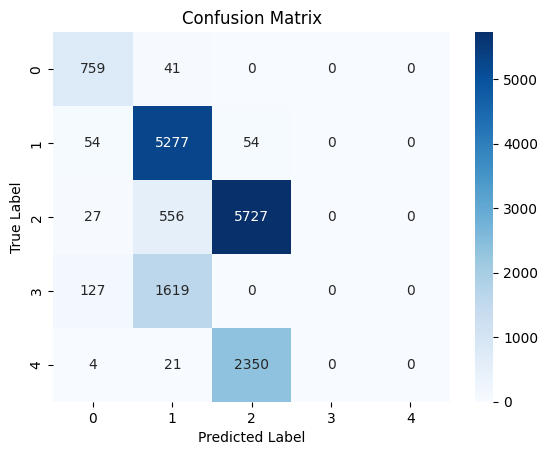

In [104]:
param_grid = {
    'n_clusters': [5, 10, 12, 15],
    'tol': [0.01, 0.001]
}

model = CustomKMeans(random_state=0)
grid_search = GridSearchCV(model, param_grid, scoring='rand_score', cv=2, n_jobs=-1)
_, _, results = estimate_model("CustomKMeans", model, grid_search, X_scaled, y, results)

### KMeans

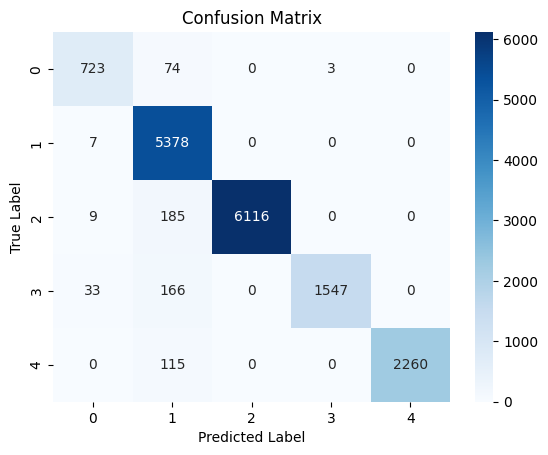

In [105]:
param_grid = {
    'n_clusters': [10, 12, 15],
    'init': ['random', 'k-means++'],
    'max_iter': [100, 200]
}

model = KMeans()
grid_search = GridSearchCV(
    model,
    param_grid,
    scoring='rand_score',
    cv=2,
    n_jobs=-1
)
_, _, results = estimate_model("SklearnKMeans", model, grid_search, X_scaled, y, results)

### DBSCAN

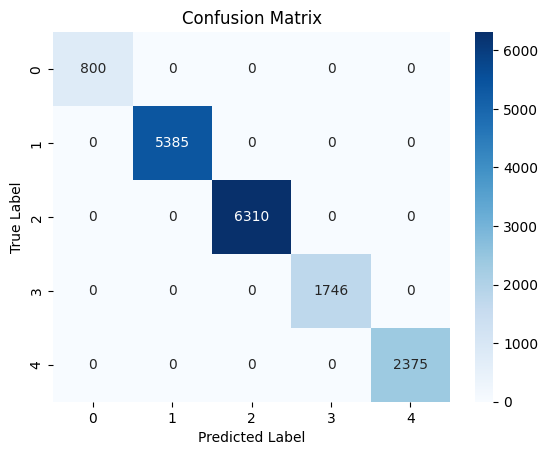

In [106]:
param_grid = {
    'eps': [1, 0.5, 2],
    'min_samples': [1],
    'algorithm': ['kd_tree', 'auto'],
    'leaf_size': [30, 50],
    'metric': ['euclidean'],
    'p': [None],
}

model = DBSCAN()
grid_search = GridSearchCV(model, param_grid, scoring='rand_score', cv=2, n_jobs=-1)
_, _, results = estimate_model('DBSCAN', model, grid_search, X_scaled, y, results)

### Вывод

In [107]:
results

,model,training_time,homogeneity_score,completeness_score,rand_score,f1_score,accuracy_score,precision_score,recall_score
0,CustomKMeans,0 days 00:00:01.337844,0.479664,0.764404,0.774475,0.607641,0.707932,0.532713,0.707932
0,SklearnKMeans,0 days 00:00:01.048264,0.880277,0.894996,0.964464,0.964542,0.964372,0.967169,0.964372
0,DBSCAN,0 days 00:00:23.543150,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


CustomKMeans и SKLearnKMeans обучились довольно быстро и показали неплохой результат. Однако библиотечная реализация KMeans выигрывает как по времени обучения, так и по качеству результата. DBSCAN ообучался значительно медленнее остальных, но показал отличный результат.

## Обучение на данных сниженной размерности

Поскольку датасет содержит больше 60 признаков, попробуем снизить размерность с помощью PCA и обучить модели снова.

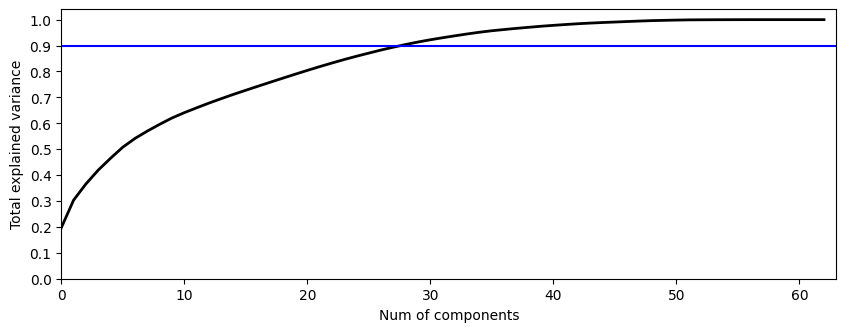

In [108]:
pca = PCA().fit(X_scaled)

plt.figure(figsize=(10,3.5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Num of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
#plt.axvline(30, c='b')
plt.axhline(0.9, c='b')
plt.show();

Можно заметить, что 90% смещения объястяется примерно в 30 компонентах. Поэтому попробуем уменьшить количество фич до 30

In [109]:
pca = PCA(n_components=30)
X_pca = pca.fit_transform(X_scaled)

### Custom K-means

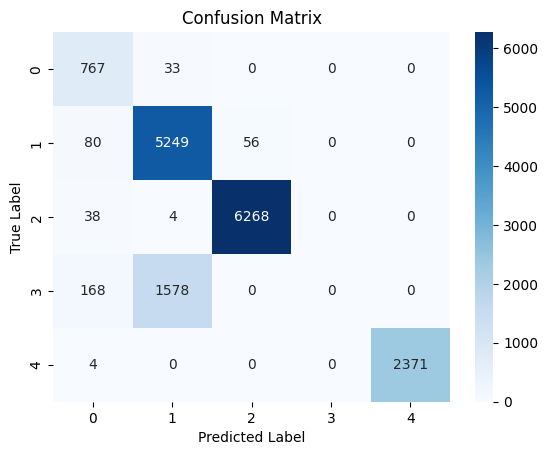

In [110]:
param_grid = {
    'n_clusters': [5, 10, 12, 15],
    'tol': [0.01, 0.001]
}

model = CustomKMeans(random_state=0)
grid_search = GridSearchCV(model, param_grid, scoring='rand_score', cv=2, n_jobs=-1)
_, _, results = estimate_model("CustomKMeans+PCA", model, grid_search, X_pca, y, results)

### K-means

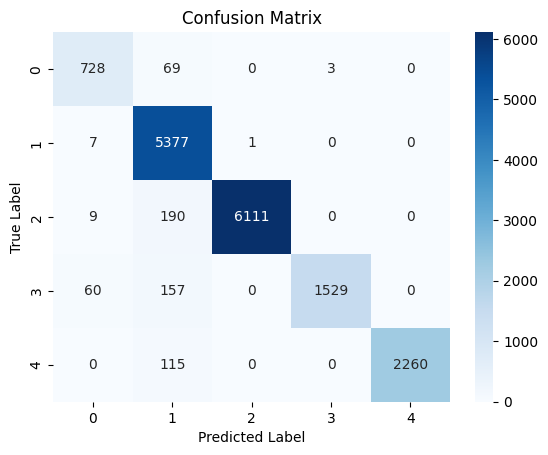

In [111]:
param_grid = {
    'n_clusters': [10, 12, 15],
    'init': ['random', 'k-means++'],
    'max_iter': [100, 200]
}

model = KMeans()
grid_search = GridSearchCV(
    model,
    param_grid,
    scoring='rand_score',
    cv=2,
    n_jobs=-1
)
_, _, results = estimate_model("SklearnKMeans+PCA", model, grid_search, X_pca, y, results)

### DBSCAN

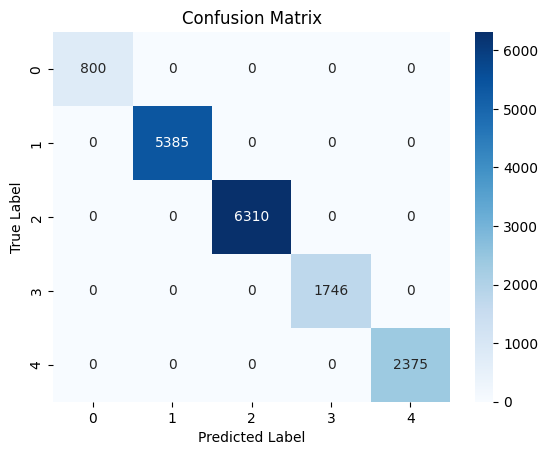

In [113]:
param_grid = {
    'eps': [1, 0.5, 2],
    'min_samples': [1],
    'algorithm': ['kd_tree', 'auto'],
    'leaf_size': [30, 50],
    'metric': ['euclidean'],
    'p': [None],
}

model = DBSCAN()
grid_search = GridSearchCV(model, param_grid, scoring='rand_score', cv=2, n_jobs=-1)
_, _, results = estimate_model('DBSCAN+PCA', model, grid_search, X_pca, y, results)

### Вывод

In [114]:
results

,model,training_time,homogeneity_score,completeness_score,rand_score,f1_score,accuracy_score,precision_score,recall_score
0,CustomKMeans,0 days 00:00:01.337844,0.479664,0.764404,0.774475,0.607641,0.707932,0.532713,0.707932
0,SklearnKMeans,0 days 00:00:01.048264,0.880277,0.894996,0.964464,0.964542,0.964372,0.967169,0.964372
0,DBSCAN,0 days 00:00:23.543150,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0,CustomKMeans+PCA,0 days 00:00:00.209726,0.776990,0.913106,0.924551,0.837152,0.881981,0.802096,0.881981
0,SklearnKMeans+PCA,0 days 00:00:00.555640,0.878137,0.891238,0.964224,0.963376,0.963228,0.966053,0.963228
0,DBSCAN+PCA,0 days 00:00:11.017408,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Можно заметить, что время обучения моделей на данных уменьшенной размерности снизилось.

Интересно отметить, что качетво модели CustomKMeans увеличилось на данных меньшей размерности. Качество модели SklearnKMeans совсем незначительно ухудшилось. А DBSCAN в обоих случаях показал отличный результат, при этом имея самое большое время обучения.

## Визуализация

### PCA

Визуализируем данные снижением размерности до 2

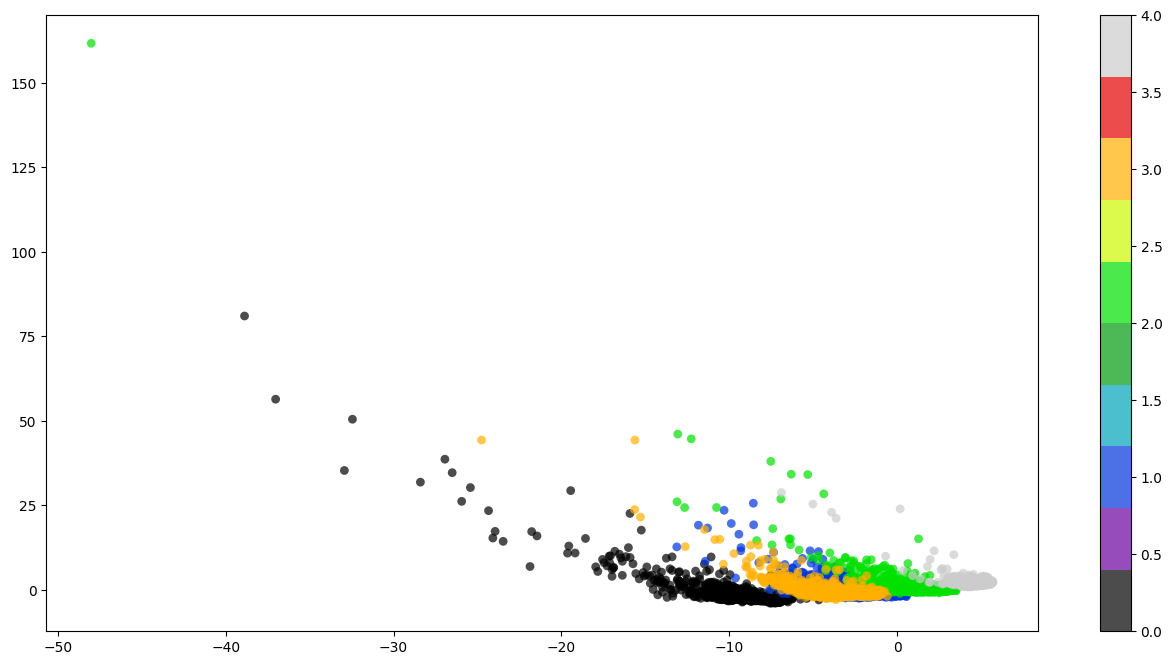

In [116]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_scaled)

plt.figure(figsize=(16, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar();

Можно различить 5 групп, но они расположены довольно близко друг к другу.

И снижением размерности до 3.

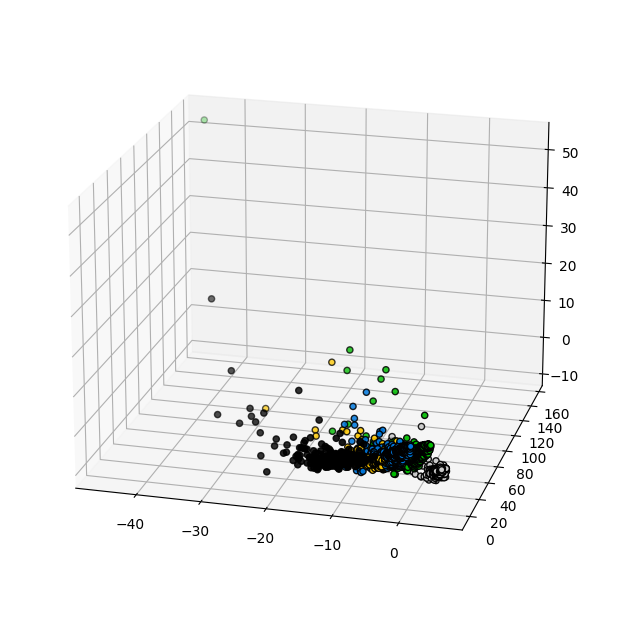

In [117]:
fig = plt.figure(1, figsize=(8, 6))
plt.clf()

ax = fig.add_subplot(111, projection="3d", elev=48, azim=134)
ax.set_position([0, 0, 0.95, 1])
ax.view_init(azim=285, elev=20)
plt.cla()
pca = PCA(n_components=3)
X_3d = pca.fit_transform(X_scaled)

colors = plt.cm.nipy_spectral(np.linspace(0, 1, 5)) # Create 8 distinct colors
ax.scatter(X_train_3d[:, 0], X_train_3d[:, 1], X_train_3d[:, 2], c=[colors[int(i)] for i in y_train], edgecolor="k")

Здесь группы не очень хорошо различимы.

### t-SNE

Теперь визуализируем данные с помощью t-SNE, предварительно понизив размерность с помощью PCA

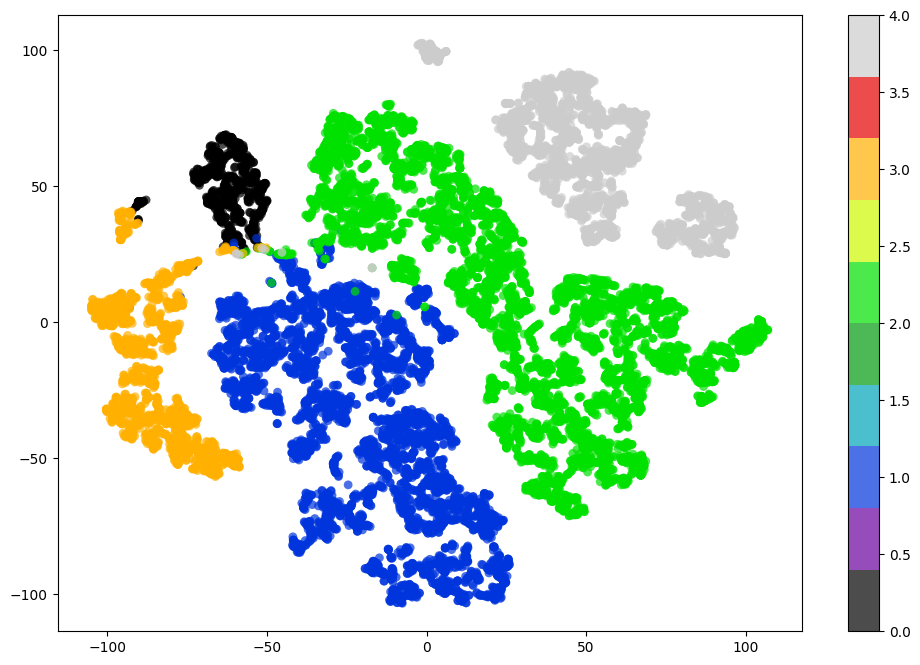

In [118]:
pca = PCA(n_components=5)
X_reduced = pca.fit_transform(X_scaled)

tsne = TSNE(random_state=42)
X_tsne = tsne.fit_transform(X_reduced)

plt.figure(figsize=(12, 8))
plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=y,
    edgecolor="none",
    alpha=0.7,
    s=40,
    cmap=plt.cm.get_cmap("nipy_spectral", 10),
)
plt.colorbar();

Теперь группы различимы гораздо лучше.